# Machine Learning on original (clean) dataset

In [1]:
# Data tools
import pandas as pd
import numpy as np
# Graph Tools
import matplotlib.pyplot as plt
import seaborn as sns
# File tools
from joblib import dump, load
# Sstatistics and machine learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

## Importing data and preparing it for ML


In [2]:
# Import cleaned data
df = pd.read_csv("data_air/AB_data_clean.csv")
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,neighbourhood_other,neighbourhood_other_label,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,Other,29,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,Midtown,25,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# Manage Na values in dataframe
df.isna().sum()

id                                      0
name                                   15
host_id                                 0
host_name                              21
neighbourhood_group                     0
neighbourhood                           0
latitude                                0
longitude                               0
room_type                               0
price                                   0
minimum_nights                          0
number_of_reviews                       0
last_review                          9913
reviews_per_month                    9913
calculated_host_listings_count          0
availability_365                        0
neighbourhood_other                     0
neighbourhood_other_label               0
neighbourhood_group_Bronx               0
neighbourhood_group_Brooklyn            0
neighbourhood_group_Manhattan           0
neighbourhood_group_Queens              0
neighbourhood_group_Staten Island       0
room_type_Entire home/apt         

In [3]:
print(df[df['last_review'].isna()].groupby('number_of_reviews').size())
print(df[df['reviews_per_month'].isna()].groupby('number_of_reviews').size())

number_of_reviews
0    9913
dtype: int64
number_of_reviews
0    9913
dtype: int64


In [4]:
df['last_review'] = df['last_review'].fillna(0) #As SciKit does not handle colums with Nan values we replace them with 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

### Making datasets for the machine learning algorithm
Here we choose what features we will be using to predict the price of a condo. 
Features are dropped either because we have encoded the varriable such as room_type and thus uses it diffrently. Or because it is irrelevant to price, such as the id of the listing or the name of the Airbnb host.

In [10]:
# Display the possible features of the dataframe
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other', 'neighbourhood_other_label',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

In [6]:
# Choose which features not to include in the calculation estimating price.
features = df.drop(['price',
                    'id', 
                    'name', 
                    'host_id', 
                    'host_name', 
                    'neighbourhood_group',
                    'neighbourhood', 
                    'room_type',
                    'last_review',
                    'neighbourhood_other'], axis=1)
target = df.price
# Print the chosen features
print(features.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other_label',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')


## Baseline model linear regression
Here we use linear regression to draw the best possible line throug the dataset, giving us a baseline predection to compare further analysis with.

In [12]:
# Scaling data since linear regression works better on scaled data
scaler = StandardScaler()
base_features = scaler.fit_transform(features)

# To do regression we first need to make a sample of our data to make the regression analysis on, and the a seperate chunk of data to test that analysis on.
test_fraction = 0.2 # We chose to keep 20% of the dataset seperate to test the regression we make


# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(base_features, target, test_size = test_fraction, random_state=3546)
# Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 16) 	Testing Features Shape:	 (9743, 16)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [13]:
# Make a prediction of price via linear regression
reg_lin = LinearRegression().fit(X_train, y_train)
y_pred = reg_lin.predict(X_test)
print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 79.4866


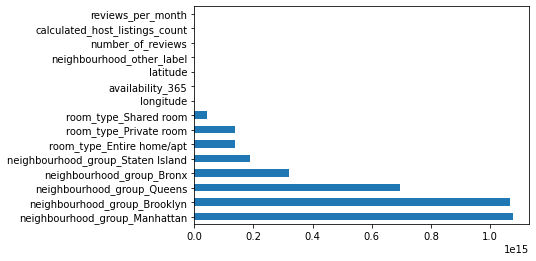

In [14]:
# Show the features most important in making the prediction above 
pd.Series(np.abs(reg_lin.coef_), index=features.columns).nlargest(15).plot(kind='barh')
plt.show()

By finding the mean absolute error (MAE) of the predictions made by the linear regression model on the test data, we now have a baseline MAE of approximately 79.5\\$ to beat. (The smaller this number the better.) We also plotted the absolute value of the coifficients of the different features in the model, to see which influence the predictions the most. Here we see that the borough (``neighbourhood_grup``) is the most influencial followed by the ``room type``.

## Decision Tree
In this section we try to find a better model than the simple linear regression. We select a decision tree to allow non-linearity in the predictions. Also this time we do a grid searh to find good hyperparameters for the model.

In [45]:
# Just like with the linear regression above we set aside 20% of the dataset for testing.
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_fraction, random_state=3546)
# Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 16) 	Testing Features Shape:	 (9743, 16)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [46]:
parameters = {'criterion':('mse', 'poisson'), 'max_depth':[1, 5, 10, 15, 20]} #'friedman_mse' gives same results as mse, 'mae' is 60 times slower than mse and poisson

reg_tree = DecisionTreeRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_tree, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=3546),
             param_grid={'criterion': ('mse', 'poisson'),
                         'max_depth': [1, 5, 10, 15, 20]},
             scoring='neg_mean_absolute_error')

In [47]:
df_reg_tree = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_tree.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.344136,0.031923,0.009351,0.001209,mse,10,"{'criterion': 'mse', 'max_depth': 10}",-70.131751,-71.948972,-73.823899,-71.713050,-71.073480,-71.73823,1.218009,1
1,0.180028,0.005640,0.007295,0.001075,mse,5,"{'criterion': 'mse', 'max_depth': 5}",-71.746204,-72.710705,-72.873362,-71.709156,-71.227623,-72.05341,0.632324,2


In [48]:
reg_tree_best = reg_seach.best_estimator_
y_pred = reg_tree_best.predict(X_test)

print(f'Decision tree has {reg_tree_best.tree_.node_count} nodes with maximum depth {reg_tree_best.tree_.max_depth}.')
print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Decision tree has 1133 nodes with maximum depth 10.
Mean absolute error (on test data): 71.0034


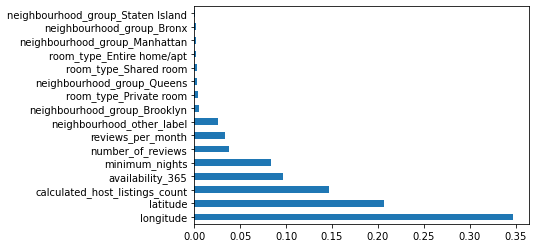

In [50]:
# Again we see the features of the regression displayd by relevans
pd.Series(reg_tree_best.feature_importances_, index=features.columns).nlargest(20).plot(kind='barh')
plt.show()

By using a decision tree we have been able to cut the Mean Absolute Error from approximately 79.5 down to 71 by dividing the dataset into 1133 smaller nodes before doing the regression.
This is a good improvement, but we will still try to improve upon it further in the next section where we turn our decision tree into a random forest.
For the best decision tree we also plotted the feature importance to see if it agreed with the linear regression model. Surprisingly, it shows almost the opposite as the coifficient plot for the linear regression model.  

## Random Forest
To enhance our prediction we use the Random Forest technique which combines several decisions trees like the one above to make many a single prediction.

In [15]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_fraction, random_state=3546)
# Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 16) 	Testing Features Shape:	 (9743, 16)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [16]:
# This is where the random forest differs from simple decision tree. We ensemble up to 200 trees to find the best tree to continue with.
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [17]:
# Cross validate and sort by highest score 
df_reg_forest = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,38.658959,2.541454,0.345985,0.059571,mse,10,200,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-66.869343,-67.612613,-68.225995,-66.970215,-67.024029,-67.340439,0.513303,1
3,31.243877,2.100210,0.261325,0.032496,mse,10,150,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-66.861770,-67.626377,-68.225444,-67.027251,-67.097402,-67.367649,0.499514,2


In [18]:
reg_forest_best = reg_seach.best_estimator_
y_pred = reg_forest_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 68.6235


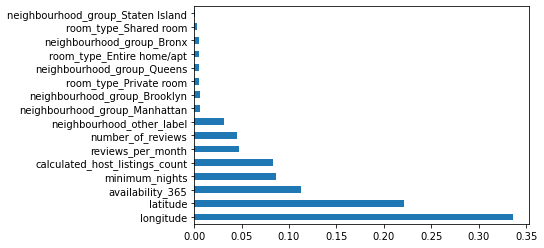

In [19]:
pd.Series(reg_forest_best.feature_importances_, index=features.columns).nlargest(20).plot(kind='barh')
plt.show()

By using a Random Forest we have been able to cut the Mean Absolute Error down just a bit further to around 68.6. This is again a fine improvement, however, we are not quite done with the random forest method.
Below we attempt to improve upon our random forrest model, by doing feature selection. 
This time we see that the assignment of feature iimportance has not changed much between the two models.

## Random Forest with feature selection

Here the feature selection is done all in one step, based on a threshold on the feature importance that we set to be 0.005. 

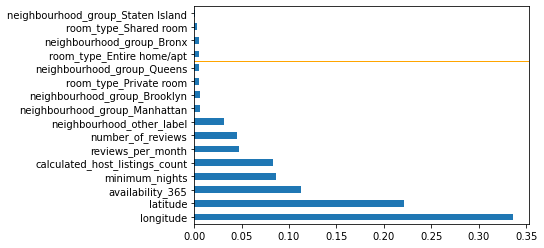

In [56]:
# Here we display featues of our random forest and the threshold for when we consider a feature unimportant
df_reg_forest_feat_im = pd.Series(reg_forest_best.feature_importances_, index=features.columns).nlargest(20)
# Threshold of (un)importance
threshold_feat_im = 0.005


threshold_plot = len(df_reg_forest_feat_im[df_reg_forest_feat_im>=threshold_feat_im])-0.5

df_reg_forest_feat_im.plot(kind='barh')
plt.axhline(y=threshold_plot,linewidth=1, color='orange')
plt.show()

In [57]:
# Choose which featues not to include in the calculation
features_select = features.drop(df_reg_forest_feat_im[df_reg_forest_feat_im<threshold_feat_im].index, axis=1)
target = df.price

print(features_select.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other_label',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'room_type_Private room'],
      dtype='object')


In [58]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features_select, target, test_size = test_fraction, random_state=3546)
# Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 12) 	Testing Features Shape:	 (9743, 12)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [61]:
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest_select = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest_select, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [62]:
df_reg_forest_select = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest_select.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,25.402642,0.300159,0.251938,0.003771,mse,10,200,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-66.864296,-67.513734,-68.240765,-66.962594,-66.921412,-67.300560,0.524925,1
2,13.399523,0.853090,0.139017,0.023172,mse,10,100,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-66.875706,-67.555974,-68.244212,-67.047758,-66.856761,-67.316082,0.528371,2


In [63]:
reg_forest_select_best = reg_seach.best_estimator_
y_pred = reg_forest_select_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 68.5127


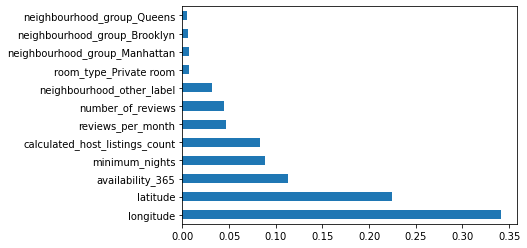

In [64]:
pd.Series(reg_forest_select_best.feature_importances_, index=features_select.columns).nlargest(20).plot(kind='barh')
plt.show()

As can be seen feature selection did not make a lot of diffrence to the random forest model. The mean absolute error went from 68.6 to 68.5, and the feature importance also looks to have stayed almost the same. Perhaps this is a result of the thredshold being to low, or maybe it is the best performance one can expect from a random forest model restricted to 200 trees.

## Random forest for the website
Here we genereate the random forest used on page 9 of the website to suggest prices for Airbnb condos.
As we saw above that neighborhood groups are largely irrelevant as the feature importance is subsumed by the ``latitude`` and ``longtitude`` features, thus these are all dropped for the website predictor. The ``reveiws_per_month`` feature is also droped since this would not make too much sence for a Airbnb host to know in advance when pricing a condo.

In [7]:
# Removeing irrelevant features
features_web = features.drop(['reviews_per_month',
                              'neighbourhood_other_label',
                              'neighbourhood_group_Bronx',
                              'neighbourhood_group_Brooklyn',
                              'neighbourhood_group_Manhattan', 
                              'neighbourhood_group_Queens',
                              'neighbourhood_group_Staten Island'], axis=1)
target = df.price

print(features_web.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')


In [66]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features_web, target, test_size = test_fraction, random_state=3546)
# Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 9) 	Testing Features Shape:	 (9743, 9)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [67]:
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest_web = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest_web, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [68]:
df_reg_forest_web = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest_web.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,17.098092,1.426560,0.198983,0.019181,mse,10,150,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-67.058696,-67.740407,-68.501693,-67.115527,-66.988532,-67.480971,0.576809,1
4,23.541994,1.949108,0.301652,0.024079,mse,10,200,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-67.054049,-67.755101,-68.531991,-67.108138,-66.959011,-67.481658,0.595566,2


In [69]:
reg_forest_web_best = reg_seach.best_estimator_
y_pred = reg_forest_web_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 68.7354


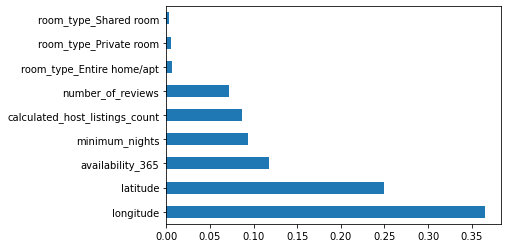

In [70]:
# Show features sorted by importance
pd.Series(reg_forest_web_best.feature_importances_, index=features_web.columns).nlargest(20).plot(kind='barh')
plt.show()

Our final random forest model, usable on the website shows a Mean Absolute Error of 68.7 which is comparable to the two other random forest models presented.
This is an improvemnt in performace of 14% over det linear regression model which had a Mean Absolute Error of 79.5.

In [71]:
# Save our model in a format that is usable on the website
dump(reg_forest_web, 'model_forest_web.joblib')

['model_forest_web.joblib']